## Analysis of the logistical regression run on technical indicators

In [1]:
import os
os.chdir('../src')

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn import metrics

In [28]:
featureset = 'indicators1'

df = pd.read_hdf('../data/features/technical.h5', key=featureset)
df['preds'] = pd.read_hdf('../data/predictions/logistic_{}.h5'.format(featureset), key='predictions')
df.preds = df.preds
df.target = df.target > 0
df = df.dropna()

importances = pd.read_hdf('../data/predictions/logistic_{}.h5'.format(featureset), key='importances')
print('accuracy', metrics.accuracy_score(df.target, df.preds > 0.5))
print('AUC', metrics.roc_auc_score(df.target, df.preds))

accuracy 0.5378477690288714
AUC 0.5513636896459841


In [4]:
importances.sort_values()


WILLR_2                -0.164405
WILLR_0.25             -0.162493
MINUS_DM_2             -0.156863
MOM_2                  -0.153168
PLUS_DM_0.25           -0.128439
BBANDS_up_2std         -0.121107
APO_0.25               -0.120602
RSI_0.25               -0.118305
CMO_0.25               -0.118305
ULTOSC_0.25            -0.114892
MINUS_DM_0.25          -0.095435
PLUS_DI_2              -0.093369
ROCR_0.25              -0.075022
STOCHRSI_d_2           -0.072495
MINUS_DI_0.25          -0.054859
HT_PHASOR_inphase      -0.048933
BOP                    -0.036505
SAR_Signal             -0.031374
HT_SINE_leadsine       -0.031021
ROCR_2                 -0.022199
HT_DCPHASE             -0.021156
ADX_0.25               -0.017936
HT_TREND_/             -0.012192
ADX_2                  -0.011939
NATR_2                 -0.009641
AROON_up               -0.005449
HT_PHASOR_quadrature   -0.004586
ADOSC_0.25             -0.001302
PPO_0.25               -0.001013
ULTOSC_2                0.002343
          

## Predictions

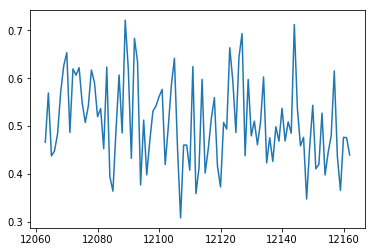

In [15]:
plt.plot(probs[10000:10100])

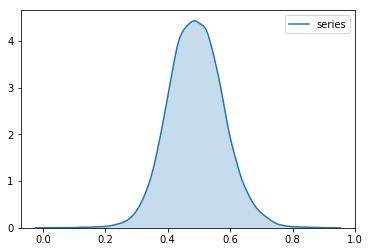

In [16]:
sns.kdeplot(probs[10000:], shade=True)

In [24]:
df['probs'] = probs

## Precision & recall

When trading, missed opportunities don't hurt as much as predictions that the market will rise, although it falls. In the long run, it might not matter in terms of expected value, but the less we trade, the less we are exposed to risk. This means that we care more about being right, when the model predicts an uptrend, than when it predicts a downtrend (Let's say we are not shorting). This measure of *being right when you predict up* is called the **precision** and the measure of *predicting up when the market goes up* is called the **recall**. We care more about the precision than about the recall, so we can say that we only predict an increase, when the model is confident about that increase with some probability.

One might consider using a weighted log loss that puts more emphasis on precision by setting pos_weight > 1.
```
targets * -log(sigmoid(logits)) * pos_weight +
    (1 - targets) * -log(1 - sigmoid(logits))
```

Let's try some threashold values at which we look at the *precision* and *recall* and also at how often the model would actually give positive predictions.

In [29]:
for threashold in [0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9]:
    predictions = df.preds > threashold
    print(predictions.sum() / len(predictions), 'is the postive rate for the threashold {}'.format(threashold))
    print('precision', metrics.precision_score(df.target, predictions))
    print('recall', metrics.recall_score(df.target, predictions))
    print('\n')

0.8777112860892389 is the postive rate for the threashold 0.4
precision 0.5184564962560704
recall 0.8951672862453531


0.5258162729658793 is the postive rate for the threashold 0.5
precision 0.5439262039773181
recall 0.5626187525815779


0.13408923884514437 is the postive rate for the threashold 0.6
precision 0.5768869401816473
recall 0.15216852540272616


0.04825196850393701 is the postive rate for the threashold 0.65
precision 0.5926892950391645
recall 0.056257744733581166


0.017028871391076117 is the postive rate for the threashold 0.7
precision 0.6288532675709001
recall 0.021065675340768277


0.005501312335958005 is the postive rate for the threashold 0.75
precision 0.6335877862595419
recall 0.006856670797191243


0.002162729658792651 is the postive rate for the threashold 0.8
precision 0.6310679611650486
recall 0.0026848409748038


0.0002519685039370079 is the postive rate for the threashold 0.9
precision 0.75
recall 0.0003717472118959108




For example 0.6 seems like a nice threashold, we still get 13.4% of up predictions and are right 57.7% of the time. (On second thought, maybe it is more profitable to just throw trades against a wall).

## Prediction mean

In [30]:
df.preds.rolling(5000).mean().plot()
df.target.rolling(5000).mean().plot()

The preceding plot(target in orange, probabilities in blue) shows that the classifier's mean of the predictions significantly varies through time, so it kind of has incorporated longer term *trend* dectection. It also seems interesting, that the mean of the probabilties is kind of a version of the mean of the targets lagging behind(very significantly).

Maybe this model would thus benefit of being ensambled with a longer term model, because it seems horrendous, that the model doesn't even model the expected value of the target. Let's look at a stupid ass classifier:

In [31]:
for tf in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]:
    probs = df.target.shift(1).rolling(tf).mean()[tf:]
    print(metrics.accuracy_score(df.target[tf:], (probs > 0.5)))

0.4734797581051571
0.4749805766121412
0.4781923941118414
0.4859818972215805
0.4916297338738474
0.500052528733217
0.5019658964277455
0.5056108806872013
0.5082015664252992
0.5068027932842315
0.5114482521834295
0.5107839480439695
0.5095453605642215


It looks like it is indeed a stupid ass classifier, I will need a longer term model that is more complex, probably also a linear model because of the lack of data.

## Daily performance distribution

In [35]:
from sklearn import model_selection
def rolling_score(label, probs, time_interval=48):
    n_intervals = int(len(df) / time_interval) # roughly 1000 for time_interval=48, we want one prediction to be one day
    cv = model_selection.TimeSeriesSplit(n_splits=n_intervals)
    splits = cv.split(probs)
    performance_padded = np.zeros(len(probs))
    performance_padded[:] = np.nan
    performance = np.zeros(n_intervals)
    performance[:] = np.nan
    for i, (_, test_idx) in enumerate(splits):
        if probs.iloc[test_idx].isnull().sum() == 0:
            perf = metrics.roc_auc_score(label.iloc[test_idx], probs.iloc[test_idx])
            performance_padded[test_idx] = perf
            performance[i] = perf
    
    return performance, performance_padded

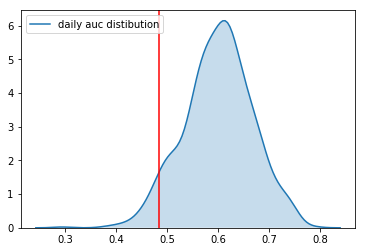

In [36]:
performance, _ = rolling_score(df.target, probs, time_interval=48)
s = pd.Series(performance).dropna()
sns.kdeplot(s, label='daily auc distibution', shade=True)
plt.axvline(s.quantile(0.05), c='red')

In [37]:
performance, _ = rolling_score(df.target, probs, time_interval=7*48)
s = pd.Series(performance).dropna()
sns.kdeplot(s, label='weekly auc distibution', shade=True)
plt.axvline(s.quantile(0.05), c='red')

In [ ]:
pd.Series(np.square(df.preds)).rolling(500).mean().plot()